### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 3
### Due: Saturday, Feb 10th at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw3_data_1.npy`. This is a (50 x 2) numpy array, with measurements in the first column and uncertainties in the second column. Using the analytic results for heteroscedastic Gaussian data from lectures, compute the sample mean and the standard error on the sample mean from for this data.

2) Reusing some approaches and tools from `Lecture_6`, write a ln-likelihood function for heteroscedastic Gaussian data, and use it in a fitting algorithm to find the best-fit mean. *Remember that scipy optimizers are set up to minimize functions.*

3) Using the same numerical technique from `Lecture_5`, compute the Fisher uncertainty estimate on the mean.

4) Using the bootstrap method, generate $1000$ bootstrap realizations of this dataset. *DO NOT use the `astroML` code. Write your own bootstrap function from scratch. Also recall that when resampling data, measurements and uncertainties should stay paired together.*

5) Repeat (2) with all $1000$ boostrap datasets to find the distribution of the sample mean. Plot a normalized histogram of these bootstrap means, and overplot a Gaussian pdf with the mean and std found in (1). Do these agree?

6) While we have fitted a heteroscedastic Gaussian to this data, let's try something else. Write some code to define a ln-likelihood for a Laplace distribution evaluated on this data. Fit simultaneously for the Laplace location parameter $\mu$ and scale parameter $\Delta$.

7) Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model. Which model is favored by the data?

8) Using the $1000$ bootstrap datasets from before, fit for the Laplacian $\mu$ and $\Delta$ for each. Make a nice `corner` plot of the distributions of $\mu$ and $\Delta$ that shows both the marginal $1$D distributions and the joint $2$D distribution. Make sure the plot has labels, shows the titles on each $1$D marginal panel, and has $68\%$ and $95\%$ levels.

9) Let's finish with a Fisher uncertainty estimate of the Laplacian parameters. Use the following code to install `numdifftools` which provides a simple way to compute derivatives. We can then compute the Hessian matrix, which is the matrix of the second derivatives of the user's function. This should be computed at the best-fit Laplacian parameters $\mu$ and $\Delta$. To finish, invert the matrix, and then take the square root. The diagonal entries will then be the Fisher uncertainties on $\mu$ and $\Delta$. How does these compare to the bootstrap distribution widths found in (8)?

In [6]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
np.random.seed(42)

import scipy

### Solution

#### 1.1

In [7]:
#read in numpy file
hw3_data = np.load('/Users/toralcm/repos/astr_8070_s24/coursework/homeworks/hw_data/hw3_data_1.npy');

In [8]:
np.load('/Users/toralcm/repos/astr_8070_s24/coursework/homeworks/hw_data/hw3_data_1.npy')

array([[2.97207735, 0.93806458],
       [1.98824293, 1.40262692],
       [1.66981961, 1.97120698],
       [3.96519709, 0.60359301],
       [3.38541476, 1.29698654],
       [4.24894584, 1.68629961],
       [3.69290063, 1.06277049],
       [4.33198366, 1.28038671],
       [2.49401178, 1.22485083],
       [1.89419429, 1.40555012],
       [2.04203146, 1.30841409],
       [4.15394176, 1.97421998],
       [4.14130534, 1.59510787],
       [4.21256076, 1.4295954 ],
       [4.47047556, 0.9776734 ],
       [4.29385594, 1.47949413],
       [3.68668822, 0.96958318],
       [4.67658913, 1.53171867],
       [3.66326255, 0.51330266],
       [3.86702391, 0.69561611],
       [4.15062285, 0.76745015],
       [5.10972749, 1.94193392],
       [4.16180633, 1.26347131],
       [4.04294769, 1.50713396],
       [3.14447868, 1.51402808],
       [6.13017327, 1.67982047],
       [7.47431877, 1.79210525],
       [4.55226549, 0.70417746],
       [3.18937552, 1.41750426],
       [5.05068215, 1.59340252],
       [2.

In [9]:
#mean
data = hw3_data[:,0]
error = hw3_data[:,1] 
 
mu_numerator = np.sum((data)*((error)**-2))
mu_denominator = np.sum(1*((error)**-2)) 

mu = (mu_numerator)/(mu_denominator) #equation given in lecture 5
print("mean=", mu)

mean= 3.9179920346060557


In [10]:
#standard error
#sigma = np.std(hw3_data) 

sigma_mu = (np.sum(1/(error)**2))**(-1/2) #equation given in lecture 5
print("standard error on the sample mean=",sigma_mu)

standard error on the sample mean= 0.09481084100510954


<span style="color:red">Good.</span>


#### 1.2

In [1]:
#log likelihood equation
#constant = -((0.5)*np.log10(2*np.pi*sigma_mu)) #constant for a gaussian distribution, from lecture 5 -- doesnt matter here
data = hw3_data[:,0]

def ln_L(mu_L, data, errors):
    f = -((data-mu_L)**2)/(2*(errors**2)) #equation from lecture 5 for log likelihood
    return np.sum(f) 

#fitting algorithm
mu_L_guess = np.mean(data) #guess the best fit mean from the data
mean = scipy.optimize.minimize(ln_L, mu_L_guess, args=(data,sigma_mu)) #maximize the ln_L function 
                                         
best_fit_mean = mean.x #best fit mean 

print("best fit mean=", best_fit_mean)
print(mu_L_guess) #check that best_fit_mean is not just returning np.mean(data)

NameError: name 'hw3_data' is not defined

<span style="color:red">No, the sigma values used in the log likelihood function for this problem should be the errors. The best-fit mean you get from this should be exactly the same as your analytic result. -3 points.</span>

#### 1.3

In [12]:
#Fisher uncertainty estimation
def log_L(data, mu, sigma_mu):
    f_L = ((data-mu)**2)/(2*(sigma_mu**2))
    return -np.sum(f_L) #log likelihood for heteroscedastic gaussian (same as ln_L above)

#Fisher information matrix 
#For this problem, the relevant parameters in the matrix are mean and variance
def Fisher_matrix(data, mu, sigma_mu):
    d_mu = np.sum(1/(sigma_mu)**2)  #second derivative of log_L with respect to mean (mu)
    d_sigma_mu = np.sum((3*((data-mu)**2))/((sigma_mu)**4))  #second derivative of log_L with respect to variance (sigma_mu)
    F_jk = np.array([[d_mu, 0],[0, d_sigma_mu]]) #fisher information matrix
    return F_jk   #returns the fisher information matrix

F_matrix = Fisher_matrix(data, mu, sigma_mu)
inverse_F_matrix = np.linalg.inv(F_matrix)
sigma_jk = np.sqrt(inverse_F_matrix) #fisher uncertainty is the square root of the inverse of F_matrix

print("Fisher uncertainty matrix:", sigma_jk)
print("Fisher uncertainty estimate on the mean=",sigma_jk[0])
print("Fisher uncertainty estimate on the variance=", sigma_jk[1:2])

Fisher uncertainty matrix: [[0.09481084 0.        ]
 [0.         0.00045094]]
Fisher uncertainty estimate on the mean= [0.09481084 0.        ]
Fisher uncertainty estimate on the variance= [[0.         0.00045094]]


<span style="color:red">The problem here only has one parameter to estimate, since there is no `sigma_mu` (which is the uncertainty on the mean parameter estimate). The standard deviation values used in the problem should be the errors on the data. -3 points.</span> 

<span style="color:red">This is also not the same numerical technique used in `Lecture 5`. The goal was to compute the log likelihood on a grid, then take second derivatives using `np.diff`, and use the fisher formula. -2 points.
</span>

#### 1.4

In [13]:
#1000 bootstrap realizations
n = 1000 #number of bootstraps
data = hw3_data[:,0] #data set
error = hw3_data[:,1] #uncertainties of each data point

def bootstrap(data,error, n):
    bootstrap_realizations=[]
    m=len(data) #len(bootstrap realizations) = len(data)
    for _ in range(n):
        bootstrap_samples=np.random.choice(np.arange(m), size=m, replace=True) #generate new data
        data_b = data[bootstrap_samples]
        uncertainties_b = error[bootstrap_samples] #pair measurements and uncertainties
        bootstrap_realizations.append((data_b, uncertainties_b))
    return bootstrap_realizations

bootstrap_realizations = bootstrap(data, error, n)
print(bootstrap_realizations)

[(array([3.23519179, 4.7044181 , 4.47047556, 5.45355937, 5.29661353,
       4.15062285, 3.67446241, 3.46562245, 3.69313217, 3.69313217,
       1.35147524, 3.19879973, 4.04294769, 1.66981961, 5.10972749,
       4.68671169, 1.98824293, 1.35147524, 5.05068215, 4.42150207,
       1.98824293, 4.39143774, 4.03419177, 4.15062285, 3.15074159,
       3.8625051 , 3.14653177, 5.10972749, 4.94178893, 4.54079173,
       3.28702062, 5.33943461, 4.56778994, 4.81515552, 4.03419177,
       4.09244224, 4.47047556, 1.53762427, 1.53762427, 5.61515858,
       1.53762427, 4.22466725, 3.91370395, 4.39143774, 1.66981961,
       4.22466725, 3.69290063, 4.15062285, 3.58302266, 5.78739811,
       4.67658913, 3.96519709, 4.94178893, 4.03419177, 4.21256076,
       2.49401178, 5.021566  , 4.68671169, 1.98824293, 3.15810998,
       4.81515552, 4.03419177, 4.27078305, 2.84179256, 4.33198366,
       5.61515858, 6.58112816, 2.93330476, 3.10229518, 2.8891109 ,
       4.6024919 , 3.96519709, 1.98824293, 4.24894584, 3.529

<span style="color:red">This looks good.</span>

#### 1.5

In [126]:
#best fit mean of each bootstrap realization 

#log likelihood 
#use empirical log-likelihood function (we don't know the distribution yet)
def bootstrap_L(data_b, uncertainties_b, mu_b):
    likelihood_b = np.sum((data_b - mu_b)**2 / uncertainties_b**2)
    return likelihood_b

#fitting algorithm
def best_fit_mean_b(data_b, uncertainties_b):
    result = scipy.optimize.minimize(lambda mu_b: bootstrap_L(data_b, uncertainties_b, mu_b), np.mean(data_b))
    best_fit_mu_b = result.x[0] #best fit mean of each bootstrap realization
    return best_fit_mu_b

#bootstrap realizations
bootstrap_realizations = bootstrap(data, error, n) #call bootstrap realizations

#print best fit mean values
for i, realization in enumerate(bootstrap_realizations):
    data_b, uncertainties_b = realization
    best_fit_bootstrap = best_fit_mean_b(data_b, uncertainties_b)
    print(f"Bootstrap dataset {i+1}: Best fit mean = {best_fit_bootstrap}") 

Bootstrap dataset 1: Best fit mean = 3.9551139554684864
Bootstrap dataset 2: Best fit mean = 4.0046930680689306
Bootstrap dataset 3: Best fit mean = 3.951370279688822
Bootstrap dataset 4: Best fit mean = 3.9377350875092274
Bootstrap dataset 5: Best fit mean = 3.9599979843427886
Bootstrap dataset 6: Best fit mean = 3.915306153356104
Bootstrap dataset 7: Best fit mean = 3.8742276430264453
Bootstrap dataset 8: Best fit mean = 3.8187313706384427
Bootstrap dataset 9: Best fit mean = 3.8062805963483792
Bootstrap dataset 10: Best fit mean = 4.091723523645485
Bootstrap dataset 11: Best fit mean = 3.854170304104731
Bootstrap dataset 12: Best fit mean = 3.963977943199211
Bootstrap dataset 13: Best fit mean = 3.7605117207921546
Bootstrap dataset 14: Best fit mean = 3.8909769972922224
Bootstrap dataset 15: Best fit mean = 4.00097259044141
Bootstrap dataset 16: Best fit mean = 4.001985129898838
Bootstrap dataset 17: Best fit mean = 3.977217458685148
Bootstrap dataset 18: Best fit mean = 3.895390001

<span style="color:red">This is correct. In fact the procedure is the correct version of what you should have been doing in 1.2.</span>

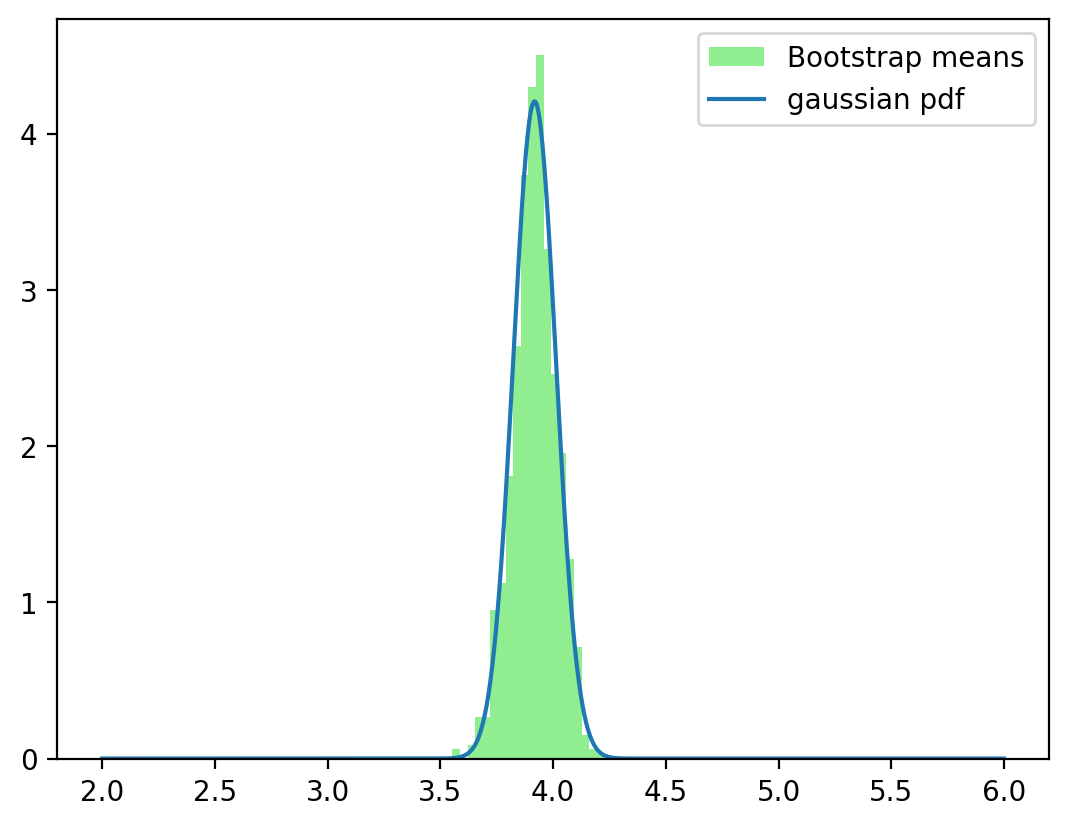

In [25]:
#plots 

#histogram
#make an array of the bootstrap best fit means
bootstrap_hist =[best_fit_mean_b(data_b, uncertainties_b) for data_b, uncertainties_b in bootstrap_realizations]
plt.hist(bootstrap_hist, bins=20, density=True,color='lightgreen', label="Bootstrap means" )


#Gaussian pdf 
xgrid = np.linspace(2, 6, 1000) #generate x values
gaussian = scipy.stats.norm.pdf(xgrid, mu, sigma_mu) #gaussian pdf with mu and sigma_mu from 1.1
plt.plot(xgrid, gaussian, label="gaussian pdf")
plt.legend()
plt.show()

<span style="color:red">Good.</span>

These argee^

#### 1.6

In [117]:
#Laplacian distribution
#mu_laplace and delta_laplace
data = hw3_data[:,0]
error = hw3_data[:,1] 

#ln-likelihood function
def ln_L_laplace(parameters, data):
     mu_laplace, delta_laplace = parameters
     #pdf_laplace = (1/2*delta_laplace)*(np.exp(-np.abs(data-mu_laplace)/delta_laplace))
     ln_laplace = -(-1/delta_laplace)*np.sum(np.abs(data-mu_laplace))
     return ln_laplace

#fitting algorithm
mu_delta_guess =  [np.mean(data), np.std(error)]  #guess the best fit mu, delta from the data 
 #maximize the ln_L_laplace function 
bestfit_results = scipy.optimize.minimize(ln_L_laplace,mu_delta_guess, args=(data,), method='COBYLA')
#needed to specify method because the optimization wouldn't converge without one. 
#COBYLA worked best after trying several different methods (mu was closest 
#to the expected value from earlier problems), although the delta seems large.
#But, I think it might be due to me using this particular method --or the distribution 
#isn't a good fit for the data
                                  
best_fit_loc, best_fit_scale = bestfit_results.x #best fit location, scale parameters



print("best fit location parameter=", best_fit_loc) 
print("best fit scale parameter=", best_fit_scale) #should be around ~1
print(bestfit_results)

best fit location parameter= 4.087300862200055
best fit scale parameter= 70.72201019876657
 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: 1.2475171855146796
       x: [ 4.087e+00  7.072e+01]
    nfev: 1000
   maxcv: 0.0


<span style="color:red">Incorrect form of log-Laplacian equation. Correct location parameter, but incorrect scale parameter. -3 points.</span>

#### 1.7

In [125]:
#calculating AIC's

#equation for AIC: AIC = -2*ln(L) +2k +2k(k+1)/N-k-1
N_data = len(data)
k_g = 2
k_laplace = 2
f_gaussian = -np.sum(((data-4.25004751)**2)/(2*(sigma_mu**2))) #plugging in best fit values from problems above
f_laplace = -(-1/70.72201019876657)*np.sum(np.abs(data-4.087300862200055))

aic_h_gaussian = -2*(np.sum(f_gaussian)) + 2*k_g + (2*k_g)*(k_g+1)/(N_data-k_g-1)

aic_laplacian = -2*f_laplace + 2*k_laplace + (2*k_laplace)*(k_laplace+1)/(N_data-k_laplace-1)

print("AIC for heteroscedastic gaussian=", aic_h_gaussian)
print("AIC for laplacian=", aic_laplacian)

AIC for heteroscedastic gaussian= 15821.22286261855
AIC for laplacian= 1.6286769691768264


Based on the AIC values, the data favors a laplacian model. 

<span style="color:red">I think this is error carried forward from the previous part of the problem. A heteroscedastic Gaussian should definitely be favored.</span>

#### 1.8

In [115]:
#fit for mu_laplace and delta_laplace for the bootstrap realizations

bootstrap_realizations = bootstrap(data, error, n) #call bootstrap realizations

#fitting

laplacian_parameters = []
for realization in bootstrap_realizations:
    mu_ell, delta_ell = scipy.stats.laplace.fit(realization)
    laplacian_parameters.append((mu_ell, delta_ell))

#laplacian doesn't have any measure of uncertainty 
#delta, mu are both parameters; use data
    
for i, (mu_ell, delta_ell) in enumerate(laplacian_parameters):
    print(f"Bootstrap dataset {i+1}: mu = {mu_ell}, delta = {delta_ell}")


Bootstrap dataset 1: mu = 1.9316792736711852, delta = 139.80074992614766
Bootstrap dataset 2: mu = 1.917377295837372, delta = 139.68384943954374
Bootstrap dataset 3: mu = 1.9237937294867546, delta = 140.60496594128978
Bootstrap dataset 4: mu = 1.9419339220836105, delta = 130.74424841785685
Bootstrap dataset 5: mu = 1.789157648943581, delta = 134.13399219686502
Bootstrap dataset 6: mu = 1.9122234165383674, delta = 133.03984078199775
Bootstrap dataset 7: mu = 1.8780956595247154, delta = 145.11717655497537
Bootstrap dataset 8: mu = 1.892207182772164, delta = 136.609610260944
Bootstrap dataset 9: mu = 1.9122234165383674, delta = 135.08264421085224
Bootstrap dataset 10: mu = 1.9407493699696132, delta = 139.96839960291345
Bootstrap dataset 11: mu = 1.939564817855616, delta = 146.0271222267016
Bootstrap dataset 12: mu = 1.9122234165383674, delta = 134.01113895205415
Bootstrap dataset 13: mu = 1.902577574517263, delta = 136.39291445887366
Bootstrap dataset 14: mu = 1.892207182772164, delta = 1

The delta values here seem really large and the mu values seem too small relative to best_fit_loc and best_fit_scale from 1.6.

<span style="color:red">The Laplace fit should only be using the data, not the uncertainties, so I think something is going haywire in the fit here. Only the bootstrapped data, not the errors, should have been fit against. -2 points.</span>

In [128]:
#corner plot
!pip install corner

In [129]:
import corner

Text(0.0, 1.0, 'Fitting laplacian parameters to 1000 bootstrap datasets')

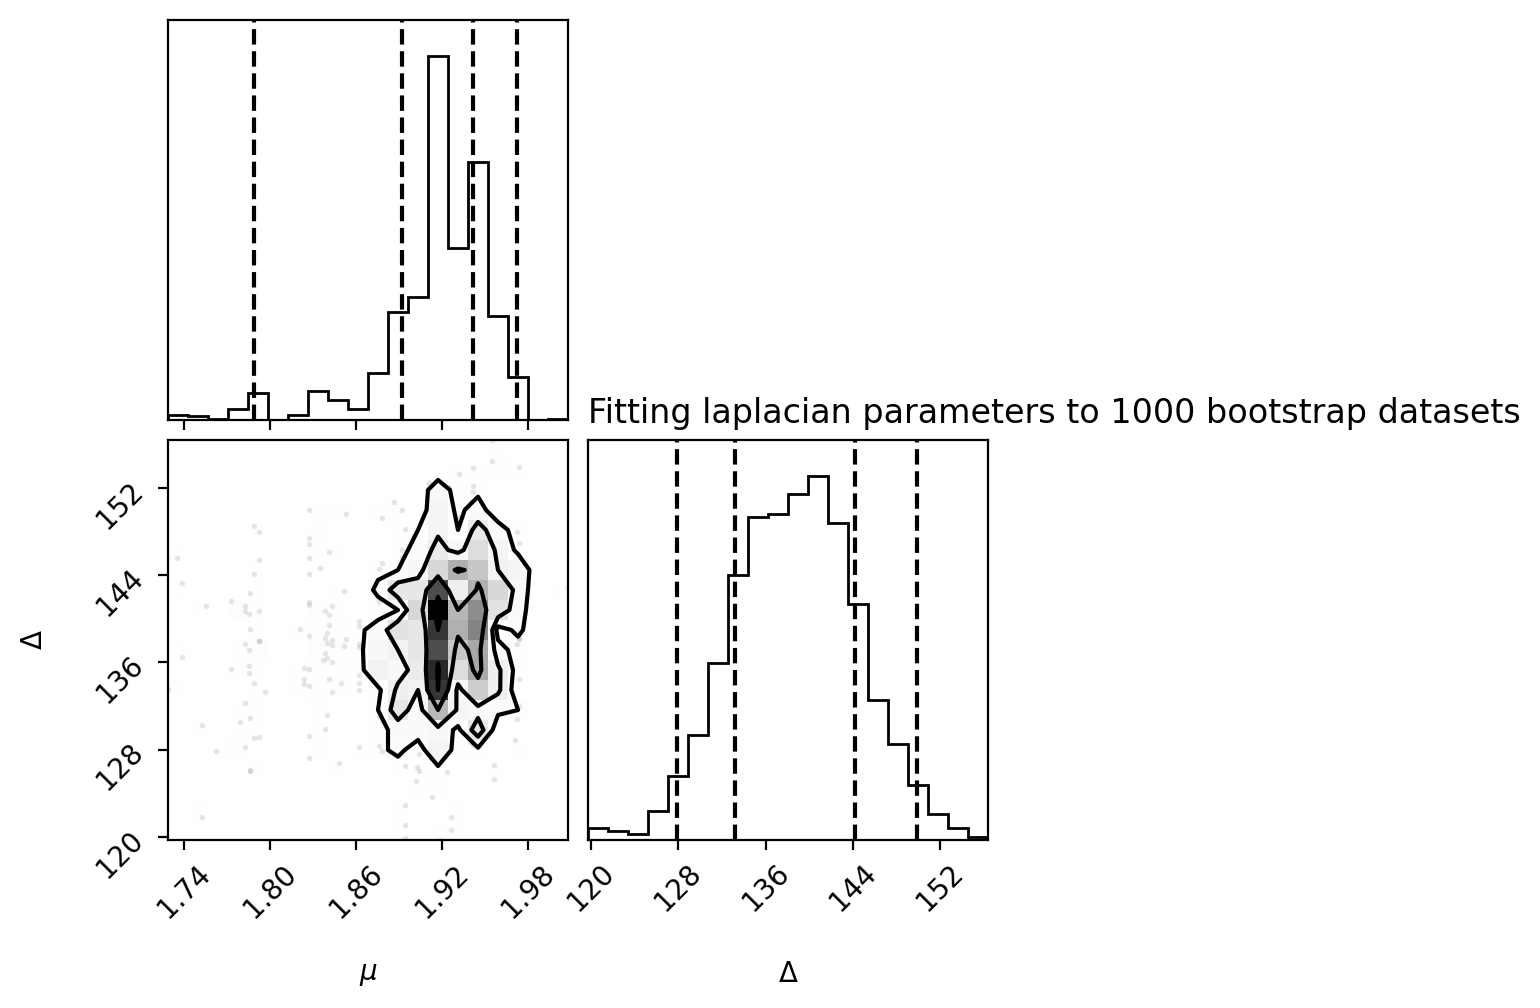

In [140]:
laplace_array = np.array(laplacian_parameters) #make an array of the values above to plot

#plot (using documentation from https://corner.readthedocs.io/en/latest/pages/quickstart/)

figure = corner.corner(laplace_array,labels=[r"$\mu$", r"$\Delta$"], quantiles=[0.16, 0.84, 0.025, 0.975], title_fmt='.4f')
plt.title('Fitting laplacian parameters to 1000 bootstrap datasets', loc='left')

#### 1.9

In [141]:
!pip install numdifftools

In [218]:
import numdifftools as nd

#use best fit parameters
best_fit_loc = 4.087300862200055
best_fit_scale = 70.72201019876657

# Define the negative log-likelihood function for Laplace distribution
def f_lnlaplace(ln_parameters):
    mu_lnlaplace, delta_lnlaplace=ln_parameters
    return -(-1/delta_lnlaplace)*np.sum(np.abs(data - mu_lnlaplace))

# beta_laplace = best fit parameters
beta_laplace = np.array([best_fit_loc, best_fit_scale])

# Calculate the Hessian matrix
H = nd.Hessian(f_lnlaplace)([beta_laplace[0], beta_laplace[1]])

# Compute the standard errors using the inverse of the Hessian matrix
sigma_laplace = np.linalg.inv(H)**0.5

print(sigma_laplace)
print("Fisher uncertainty estimate on mu=",sigma_laplace[0,0])
print("Fisher uncertainty estimate on delta=",sigma_laplace[1,1])


[[ 0.97793789  0.32318345]
 [ 0.32318345 44.77314131]]
Fisher uncertainty estimate on mu= 0.9779378915892246
Fisher uncertainty estimate on delta= 44.77314131127599


Compared to 1.8, the uncertaintiy estimates makes sense given that delta has a much wider spread than mu, as seen in the printed values of mu and delta for each bootstrap data set, and the corner plot axes.

<span style="color:red">Incorrect log Laplacian function. The combination of summing over data and taking the log of the Laplace pdf is not correct. -3 points.</span>

<span style="color:red">There were some basic misunderstandings here, Celia. You should go back and review the lecture material to make sure you understand the problems.</span>